# 1.9k: Token Connectivity Analysis

From 1.9h we know all 52 unique vectors form a single connected component.

**Question:** How does a specific token connect to the rest of the structure? Which dimensions create the adjacency links?

**Method:**
1. Select a target token ID (parameter: TARGET_TOKEN_ID)
2. Find which unique vector it corresponds to
3. Compute uint16 distances to all other unique vectors across all 2,560 dimensions
4. Identify which vectors are adjacent (differ by exactly 1 in at least one dimension)
5. For each adjacent neighbor, show:
   - Which dimension(s) create the adjacency
   - The uint16 separation in those dimensions
   - Whether the neighbor is a BH or singleton
6. Visualize the connectivity pattern

**Use case:** Understanding how distant outliers stay connected to the main structure.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Target token ID to investigate
TARGET_TOKEN_ID = 124707  # The outlier at mantissa 55 in dimension 1008

# Visualization parameters
DPI = 100
FIGSIZE = (16, 10)

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict, Counter

## Load Data

In [3]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [4]:
# Load black hole data from 1.9b
bh_path = Path(f"../tensors/{MODEL_NAME}/1.9b_core_bfloat16.safetensors")
bh_data = load_file(bh_path)

core_token_ids = bh_data["core_token_ids"].to(torch.int64)
bh_labels = bh_data["bh_labels"].to(torch.int64)
n_black_holes = bh_data["n_black_holes"].item()

print(f"\nLoaded black hole data: {n_black_holes} black holes")


Loaded black hole data: 13 black holes


In [5]:
# Load neighborhood data from 1.9g
nbhd_path = Path(f"../tensors/{MODEL_NAME}/1.9g_local_neighborhood.safetensors")
nbhd_data = load_file(nbhd_path)

full_neighborhood_token_ids = nbhd_data["full_neighborhood_token_ids"].to(torch.int64)
n_full_neighborhood = nbhd_data["n_full_neighborhood"].item()

print(f"\nLoaded neighborhood: {n_full_neighborhood:,} tokens")


Loaded neighborhood: 2,139 tokens


## Extract Unique Vectors and Categorize

In [6]:
print("\nExtracting unique vectors...\n")

# Get all vectors in the neighborhood
neighborhood_vectors_bf16 = W_bf16[full_neighborhood_token_ids]
neighborhood_vectors_uint16 = neighborhood_vectors_bf16.cpu().view(torch.uint16).numpy()

# Find unique vectors and inverse mapping
unique_vectors, first_occurrence_idx, inverse_mapping = np.unique(
    neighborhood_vectors_uint16, 
    axis=0, 
    return_index=True, 
    return_inverse=True
)

n_unique = len(unique_vectors)

print(f"✓ Found {n_unique} unique vectors")
print()

# Build mapping: unique_idx -> list of token IDs with that vector
unique_to_tokens = defaultdict(list)
for token_idx, unique_idx in enumerate(inverse_mapping):
    token_id = full_neighborhood_token_ids[token_idx].item()
    unique_to_tokens[unique_idx].append(token_id)

# Categorize each unique vector
bh_token_ids_set = set(core_token_ids[bh_labels >= 0].tolist())

# Map token_id -> BH ID for BH tokens
token_to_bh_id = {}
for i, token_id in enumerate(core_token_ids):
    bh_id = bh_labels[i].item()
    if bh_id >= 0:
        token_to_bh_id[token_id.item()] = bh_id

# For each unique vector, determine type
unique_types = []  # 'BH' or 'singleton'
unique_bh_ids = []  # BH ID (0-12) if BH, else None
unique_populations = []  # How many tokens
unique_representative_tokens = []  # Representative token ID

for unique_idx in range(n_unique):
    token_ids_for_this_vector = unique_to_tokens[unique_idx]
    unique_populations.append(len(token_ids_for_this_vector))
    unique_representative_tokens.append(token_ids_for_this_vector[0])
    
    # Check if any token is a BH
    bh_ids_for_this_vector = [token_to_bh_id[tid] for tid in token_ids_for_this_vector if tid in token_to_bh_id]
    
    if bh_ids_for_this_vector:
        unique_types.append('BH')
        unique_bh_ids.append(bh_ids_for_this_vector[0])
    else:
        unique_types.append('singleton')
        unique_bh_ids.append(None)

print(f"Unique vector breakdown:")
print(f"  BH centroids: {sum(1 for t in unique_types if t == 'BH')}")
print(f"  Singleton vectors: {sum(1 for t in unique_types if t == 'singleton')}")


Extracting unique vectors...

✓ Found 52 unique vectors

Unique vector breakdown:
  BH centroids: 13
  Singleton vectors: 39


## Find Target Token's Unique Vector

In [7]:
print(f"\nLooking for target token {TARGET_TOKEN_ID}...\n")

# Find which unique vector this token corresponds to
target_unique_idx = None

for unique_idx, token_list in unique_to_tokens.items():
    if TARGET_TOKEN_ID in token_list:
        target_unique_idx = unique_idx
        break

if target_unique_idx is None:
    raise ValueError(f"Token {TARGET_TOKEN_ID} not found in neighborhood!")

print(f"✓ Found target token {TARGET_TOKEN_ID}")
print(f"  Unique vector index: {target_unique_idx}")
print(f"  Type: {unique_types[target_unique_idx]}")
if unique_types[target_unique_idx] == 'BH':
    print(f"  BH ID: {unique_bh_ids[target_unique_idx]}")
print(f"  Population: {unique_populations[target_unique_idx]} token(s)")
print()

# Get the target vector
target_vector = unique_vectors[target_unique_idx]


Looking for target token 124707...

✓ Found target token 124707
  Unique vector index: 51
  Type: singleton
  Population: 1 token(s)



## Compute Adjacencies

In [8]:
print(f"Computing adjacencies for token {TARGET_TOKEN_ID}...\n")

# For each other unique vector, find dimensions where they differ by exactly 1
adjacent_neighbors = []  # List of (unique_idx, dimensions_list)

for other_idx in range(n_unique):
    if other_idx == target_unique_idx:
        continue
    
    other_vector = unique_vectors[other_idx]
    
    # Compute differences across all dimensions
    diffs = np.abs(target_vector.astype(np.int32) - other_vector.astype(np.int32))
    
    # Find dimensions where diff == 1
    adjacent_dims = np.where(diffs == 1)[0].tolist()
    
    if adjacent_dims:
        adjacent_neighbors.append((other_idx, adjacent_dims))

print(f"✓ Found {len(adjacent_neighbors)} adjacent neighbors")
print()

if len(adjacent_neighbors) == 0:
    print("⚠ This token has NO adjacent neighbors!")
    print("  This contradicts 1.9h's finding of a connected component.")
    print("  Something is wrong.")
else:
    print(f"Neighbor details:")
    print()
    
    # Sort by number of dimensions (multi-dimensional adjacency)
    adjacent_neighbors.sort(key=lambda x: len(x[1]), reverse=True)
    
    for neighbor_idx, dims in adjacent_neighbors[:20]:  # Show top 20
        neighbor_type = unique_types[neighbor_idx]
        neighbor_pop = unique_populations[neighbor_idx]
        neighbor_token = unique_representative_tokens[neighbor_idx]
        
        type_str = neighbor_type
        if neighbor_type == 'BH':
            type_str = f"BH {unique_bh_ids[neighbor_idx]}"
        
        print(f"  Neighbor {neighbor_idx} (token {neighbor_token}, {type_str}, pop={neighbor_pop}):")
        print(f"    Adjacent in {len(dims)} dimension(s): {dims[:10]}{'...' if len(dims) > 10 else ''}")
    
    if len(adjacent_neighbors) > 20:
        print(f"\n  ... and {len(adjacent_neighbors) - 20} more neighbors")

Computing adjacencies for token 124707...

✓ Found 51 adjacent neighbors

Neighbor details:

  Neighbor 0 (token 139665, singleton, pop=1):
    Adjacent in 36 dimension(s): [61, 74, 371, 381, 414, 476, 506, 545, 554, 573]...
  Neighbor 1 (token 128221, singleton, pop=1):
    Adjacent in 36 dimension(s): [61, 82, 282, 381, 476, 506, 573, 619, 679, 727]...
  Neighbor 49 (token 136831, BH 9, pop=4):
    Adjacent in 36 dimension(s): [61, 282, 381, 450, 476, 506, 573, 679, 727, 900]...
  Neighbor 48 (token 132383, BH 7, pop=5):
    Adjacent in 32 dimension(s): [61, 282, 381, 476, 506, 573, 679, 727, 900, 933]...
  Neighbor 50 (token 128068, singleton, pop=1):
    Adjacent in 32 dimension(s): [61, 282, 381, 414, 476, 506, 726, 727, 733, 933]...
  Neighbor 26 (token 138322, singleton, pop=1):
    Adjacent in 31 dimension(s): [61, 381, 413, 476, 506, 573, 679, 727, 900, 933]...
  Neighbor 39 (token 126316, singleton, pop=1):
    Adjacent in 31 dimension(s): [61, 381, 476, 506, 573, 679, 704, 7

## Analyze Adjacency Dimensions

In [9]:
print("\n" + "=" * 100)
print("ADJACENCY DIMENSION ANALYSIS")
print("=" * 100)
print()

# Count how often each dimension appears in adjacency relationships
dimension_usage = Counter()
for neighbor_idx, dims in adjacent_neighbors:
    for dim in dims:
        dimension_usage[dim] += 1

# Show most important dimensions for connectivity
top_dims = dimension_usage.most_common(20)

print(f"Dimensions that create adjacency links (top 20):")
print()
for dim, count in top_dims:
    pct = 100 * count / len(adjacent_neighbors)
    print(f"  Dim {dim:4d}: connects to {count:2d} neighbors ({pct:5.1f}%)")

print()
print(f"Total dimensions involved in adjacency: {len(dimension_usage)}")
print(f"Dimensions not involved: {2560 - len(dimension_usage)}")


ADJACENCY DIMENSION ANALYSIS

Dimensions that create adjacency links (top 20):

  Dim   61: connects to 51 neighbors (100.0%)
  Dim  381: connects to 51 neighbors (100.0%)
  Dim  476: connects to 51 neighbors (100.0%)
  Dim  506: connects to 51 neighbors (100.0%)
  Dim  933: connects to 51 neighbors (100.0%)
  Dim 1275: connects to 51 neighbors (100.0%)
  Dim 1389: connects to 51 neighbors (100.0%)
  Dim 1486: connects to 51 neighbors (100.0%)
  Dim 1641: connects to 51 neighbors (100.0%)
  Dim 2223: connects to 51 neighbors (100.0%)
  Dim 2337: connects to 51 neighbors (100.0%)
  Dim 2377: connects to 51 neighbors (100.0%)
  Dim  573: connects to 50 neighbors ( 98.0%)
  Dim  679: connects to 50 neighbors ( 98.0%)
  Dim  900: connects to 50 neighbors ( 98.0%)
  Dim 1490: connects to 50 neighbors ( 98.0%)
  Dim  977: connects to 50 neighbors ( 98.0%)
  Dim 1528: connects to 50 neighbors ( 98.0%)
  Dim 2050: connects to 50 neighbors ( 98.0%)
  Dim 2064: connects to 49 neighbors ( 96.1%)

## Visualizations


Creating visualizations...



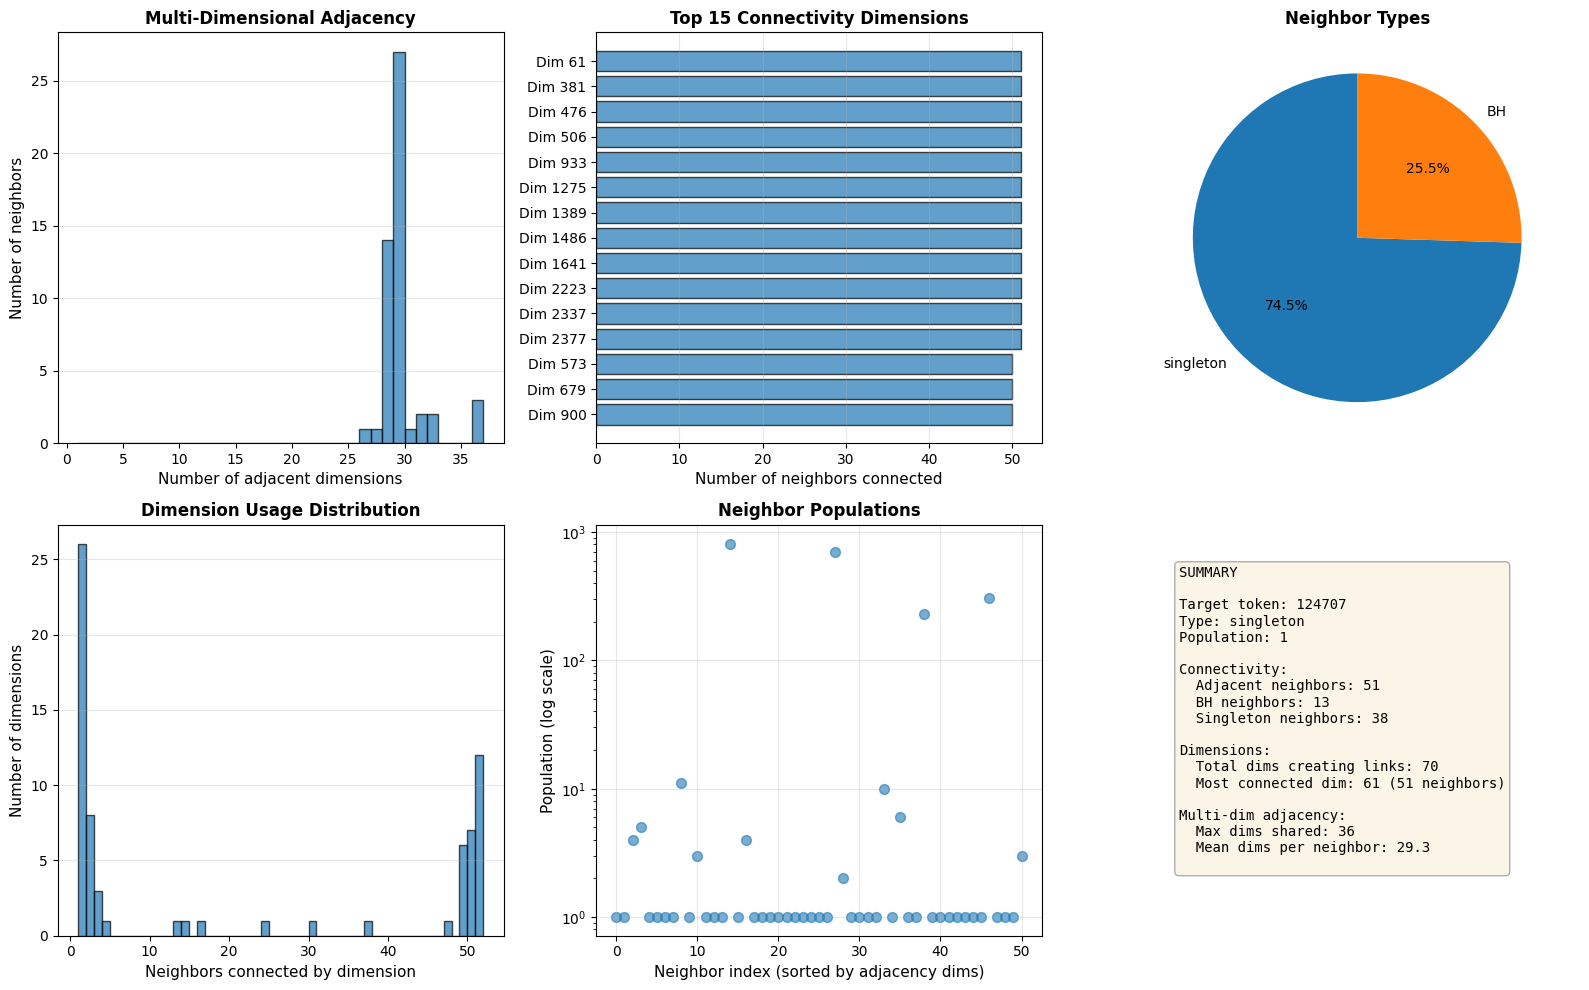

✓ Visualizations complete


In [11]:
print("\nCreating visualizations...\n")

fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

# 1. Histogram: Number of dimensions per neighbor
ax1 = plt.subplot(2, 3, 1)
n_dims_per_neighbor = [len(dims) for _, dims in adjacent_neighbors]
ax1.hist(n_dims_per_neighbor, bins=range(1, max(n_dims_per_neighbor)+2), 
         edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of adjacent dimensions', fontsize=11)
ax1.set_ylabel('Number of neighbors', fontsize=11)
ax1.set_title('Multi-Dimensional Adjacency', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Bar chart: Top dimensions for connectivity
ax2 = plt.subplot(2, 3, 2)
if top_dims:
    dims_to_plot = [d for d, c in top_dims[:15]]
    counts_to_plot = [c for d, c in top_dims[:15]]
    ax2.barh(range(len(dims_to_plot)), counts_to_plot, edgecolor='black', alpha=0.7)
    ax2.set_yticks(range(len(dims_to_plot)))
    ax2.set_yticklabels([f"Dim {d}" for d in dims_to_plot])
    ax2.set_xlabel('Number of neighbors connected', fontsize=11)
    ax2.set_title('Top 15 Connectivity Dimensions', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()

# 3. Neighbor type breakdown
ax3 = plt.subplot(2, 3, 3)
neighbor_types = [unique_types[n] for n, _ in adjacent_neighbors]
type_counts = Counter(neighbor_types)
ax3.pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%', startangle=90)
ax3.set_title('Neighbor Types', fontsize=12, fontweight='bold')

# 4. Dimension usage distribution
ax4 = plt.subplot(2, 3, 4)
usage_counts = list(dimension_usage.values())
ax4.hist(usage_counts, bins=range(1, max(usage_counts)+2), 
         edgecolor='black', alpha=0.7)
ax4.set_xlabel('Neighbors connected by dimension', fontsize=11)
ax4.set_ylabel('Number of dimensions', fontsize=11)
ax4.set_title('Dimension Usage Distribution', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5. Neighbor degree (how many neighbors does each neighbor have?)
# We'll approximate by counting their adjacencies within the neighborhood
ax5 = plt.subplot(2, 3, 5)
neighbor_populations = [unique_populations[n] for n, _ in adjacent_neighbors]
ax5.scatter(range(len(neighbor_populations)), neighbor_populations, alpha=0.6, s=50)
ax5.set_yscale('log')
ax5.set_xlabel('Neighbor index (sorted by adjacency dims)', fontsize=11)
ax5.set_ylabel('Population (log scale)', fontsize=11)
ax5.set_title('Neighbor Populations', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3)

# 6. Summary text box
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""SUMMARY

Target token: {TARGET_TOKEN_ID}
Type: {unique_types[target_unique_idx]}
Population: {unique_populations[target_unique_idx]}

Connectivity:
  Adjacent neighbors: {len(adjacent_neighbors)}
  BH neighbors: {sum(1 for t in neighbor_types if t == 'BH')}
  Singleton neighbors: {sum(1 for t in neighbor_types if t == 'singleton')}

Dimensions:
  Total dims creating links: {len(dimension_usage)}
  Most connected dim: {top_dims[0][0] if top_dims else 'N/A'} ({top_dims[0][1] if top_dims else 0} neighbors)
  
Multi-dim adjacency:
  Max dims shared: {max(n_dims_per_neighbor) if n_dims_per_neighbor else 0}
  Mean dims per neighbor: {np.mean(n_dims_per_neighbor):.1f}
"""

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Summary

In [12]:
print("\n" + "=" * 100)
print(f"SUMMARY: CONNECTIVITY FOR TOKEN {TARGET_TOKEN_ID}")
print("=" * 100)
print()

print(f"Target token: {TARGET_TOKEN_ID}")
print(f"  Unique vector index: {target_unique_idx}")
print(f"  Type: {unique_types[target_unique_idx]}")
if unique_types[target_unique_idx] == 'BH':
    print(f"  Black hole ID: {unique_bh_ids[target_unique_idx]}")
print(f"  Population: {unique_populations[target_unique_idx]} token(s)")
print()

print(f"Connectivity:")
print(f"  Adjacent neighbors: {len(adjacent_neighbors)} / {n_unique - 1} possible")
print(f"  Connection rate: {100 * len(adjacent_neighbors) / (n_unique - 1):.1f}%")
print()

neighbor_types = [unique_types[n] for n, _ in adjacent_neighbors]
print(f"Neighbor composition:")
print(f"  BH centroids: {sum(1 for t in neighbor_types if t == 'BH')}")
print(f"  Singleton vectors: {sum(1 for t in neighbor_types if t == 'singleton')}")
print()

print(f"Dimensions creating links:")
print(f"  Total dimensions involved: {len(dimension_usage)}")
print(f"  Dimensions not involved: {2560 - len(dimension_usage)}")
print()

if top_dims:
    print(f"Top 5 connectivity dimensions:")
    for dim, count in top_dims[:5]:
        pct = 100 * count / len(adjacent_neighbors)
        print(f"  Dim {dim:4d}: {count:2d} neighbors ({pct:5.1f}%)")

print()

if n_dims_per_neighbor:
    print(f"Multi-dimensional adjacency:")
    print(f"  Max dimensions shared with a single neighbor: {max(n_dims_per_neighbor)}")
    print(f"  Mean dimensions per neighbor: {np.mean(n_dims_per_neighbor):.1f}")
    print(f"  Median dimensions per neighbor: {np.median(n_dims_per_neighbor):.1f}")

print()
print("=" * 100)


SUMMARY: CONNECTIVITY FOR TOKEN 124707

Target token: 124707
  Unique vector index: 51
  Type: singleton
  Population: 1 token(s)

Connectivity:
  Adjacent neighbors: 51 / 51 possible
  Connection rate: 100.0%

Neighbor composition:
  BH centroids: 13
  Singleton vectors: 38

Dimensions creating links:
  Total dimensions involved: 70
  Dimensions not involved: 2490

Top 5 connectivity dimensions:
  Dim   61: 51 neighbors (100.0%)
  Dim  381: 51 neighbors (100.0%)
  Dim  476: 51 neighbors (100.0%)
  Dim  506: 51 neighbors (100.0%)
  Dim  933: 51 neighbors (100.0%)

Multi-dimensional adjacency:
  Max dimensions shared with a single neighbor: 36
  Mean dimensions per neighbor: 29.3
  Median dimensions per neighbor: 29.0

